In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

import sqlite3
import sys
import time

import seaborn as sns

## Loading database

Due to Jaspar's code for loading the database and handling data types being a bit more robust than mine, I have decided to start this second file for data exploration from scratch, copying over the database loading code. Currently, it is used for generating a heatmap of character vs character win percentages, but might be used for more exploration later.

Next couple cells are originally mostly Jaspar's - see his data exploration file for some more comments on it.


In [2]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = "../data/melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

In [3]:
dfs['sets_df']['best_of'] = dfs['sets_df']['best_of'].fillna(0).astype(int) 

In [4]:
players_df = dfs['players_df']
ranking_df = dfs['ranking_df']
ranking_seasons_df = dfs['ranking_seasons_df']
sets_df = dfs['sets_df']
tournament_info_df = dfs['tournament_info_df']

## Computing the character win rates

Ideally, for each individual player, we would have statistics of how well they perform playing a certain character, with their opponent also playing another given character. However, we might not have enough data for that in general, and so it might be necessary to use the global character vs. character win rates. Here, we compute those rates.

In [5]:
# Might not be best practice, but seems reasonably fast
game_data = []

for data in sets_df['game_data']:
    game_data += data
    
game_data_df = pd.DataFrame(game_data)

# melee/character -> character
# Dunno why these aren't formatted as strings by default. I'll look into that later.
game_data_df['loser_char'] = game_data_df['loser_char'].apply(lambda x: str(x).replace('melee/', ''))
game_data_df['winner_char'] = game_data_df['winner_char'].apply(lambda x: str(x).replace('melee/', ''))

# Data cleanup. Not 100% sure from where, but 'None' (as a string) shows up as a character sometimes.
# Let's just remove it here.
num_invalid = len(game_data_df[(game_data_df['loser_char'] == 'None') & (game_data_df['winner_char'] == 'None')].index)
num_total = len(game_data_df.index)
print("About {0:.2f}% of the data is invalid. Removing it.".format(100.0 * num_invalid / num_total))

game_data_df = game_data_df[(game_data_df['loser_char'] != 'None') & (game_data_df['winner_char'] != 'None')]

game_data_df

About 1.20% of the data is invalid. Removing it.


,loser_char,winner_score,winner_id,loser_id,winner_char,loser_score,stage
0,peach,1.0,1004,1032,jigglypuff,0.0,Battlefield
1,peach,2.0,1004,1032,jigglypuff,0.0,Yoshi's Story
2,peach,2.0,1004,1032,jigglypuff,0.0,Yoshi's Story
3,peach,1.0,1017,1039,captainfalcon,0.0,Dream Land
4,peach,2.0,1017,1039,captainfalcon,0.0,None
...,...,...,...,...,...,...,...
1609192,marth,NaN,2791218,908884,sheik,0.0,None
1609193,marth,NaN,2791218,908884,sheik,0.0,None
1609194,fox,NaN,180567,2791218,falco,0.0,None
1609195,sheik,NaN,180567,2791218,fox,0.0,None


In [12]:
# Also slightly janky. Compute total character vs character wins.
# Need a dummy column in there initially (winner_id) to get the .count() to work properly
char_vs_char_totals_df = game_data_df[['winner_char', 'loser_char', 'winner_id']].groupby(by=['winner_char', 'loser_char']).count().unstack()

# Remove that leftover winner_id, which is the top level column after the .unstack()
char_vs_char_totals_df.columns = char_vs_char_totals_df.columns.droplevel()

# Rows and columns seem to be ordered alphabetically by default
# We can order by number of wins with that character instead
# (should be roughly equivalent to character popularity)
wins_df = char_vs_char_totals_df.sum(axis=1)
wins_df = wins_df.sort_values(ascending=False)

# Reorder rows and columns, respectively
char_vs_char_totals_df = char_vs_char_totals_df.reindex(wins_df.index)
char_vs_char_totals_df = char_vs_char_totals_df[wins_df.index]

# Compute win percentages
# Convert to float prematurely so we don't get errors about setting incompatible data types
char_vs_char_rates_df = char_vs_char_totals_df.copy().astype(float)
characters = list(char_vs_char_rates_df.index)

for char_1 in characters:
    for char_2 in characters:
        wins   = char_vs_char_totals_df.loc[char_1, char_2]
        losses = char_vs_char_totals_df.loc[char_2, char_1]

        char_vs_char_rates_df.loc[char_1, char_2] = 100 * wins / (wins + losses)

# For display purposes only, remove the absurd amount of decimals
char_vs_char_rates_df.astype(int)

loser_char,fox,falco,marth,sheik,captainfalcon,jigglypuff,peach,luigi,samus,ganondorf,...,mrgameandwatch,zelda,roy,younglink,ness,kirby,random,bowser,pichu,mewtwo
winner_char,,,,,,,,,,,,,,,,,,,,,
fox,50,51,51,52,52,51,49,50,48,53,...,66,55,54,60,60,67,54,65,61,60
falco,48,50,49,48,50,46,43,50,46,50,...,59,52,53,50,55,56,50,60,55,59
marth,48,50,50,44,48,47,48,48,46,43,...,57,47,53,55,56,52,49,58,53,57
sheik,47,51,55,50,51,52,50,51,54,54,...,65,59,55,56,63,57,51,63,58,62
captainfalcon,47,49,51,48,50,50,50,54,52,52,...,56,59,57,58,57,53,50,61,51,62
jigglypuff,48,53,52,47,49,50,46,47,50,49,...,52,41,57,52,56,55,50,55,53,60
peach,50,56,51,49,49,53,50,53,52,50,...,58,50,65,56,55,71,54,64,68,62
luigi,49,49,51,48,45,52,46,50,45,40,...,57,46,58,52,59,52,57,56,62,50
samus,51,53,53,45,47,49,47,54,50,43,...,62,49,57,50,54,62,51,63,66,65


## Create a heatmap

Here, we create a heatmap instead of just a table of numerical values.

<Axes: xlabel='loser_char', ylabel='winner_char'>

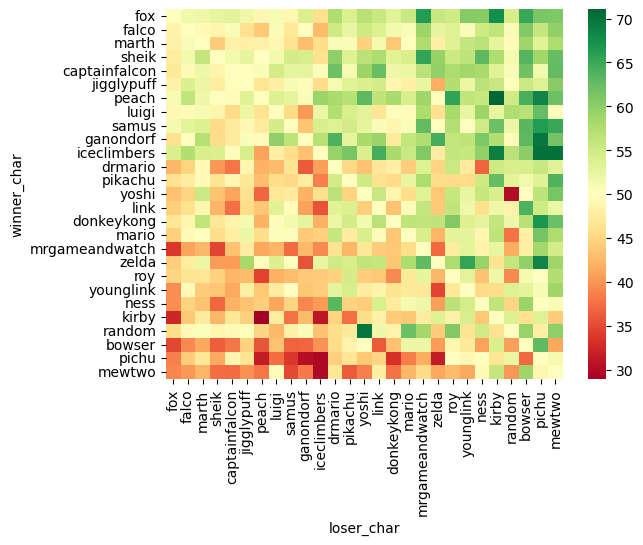

In [24]:
# We can limit ourselves to the n most popular characters, to avoid having it be too massive
max_chars = 30

limited_df = char_vs_char_rates_df.iloc[:max_chars][char_vs_char_rates_df.columns[:max_chars]]
limited_df

sns.heatmap(limited_df, cmap='RdYlGn', center=50, xticklabels=True, yticklabels=True)